In [23]:
import pandas as pd
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import seaborn as sns                                  # Make the plots nicer to look at
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy.signal import find_peaks
import glob
import os
from scipy import stats

In [2]:
sys.path.append('External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

# In case you want to load function from a jupyter notebook from the current working directory, you can use the function below:
#   from ipynb.fs.full.ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
#PDFer til vores fit
def line(x,a,b):
    """Just a line"""
    return a*x+b

def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def exp_pdf(x, a, V0, s0):
    """Second Degree polynomial"""
    return 0.5 * a * x**2 + V0 * x + s0

In [4]:
#regn weighted mean og usikkerheder på input dataframe
def w_mean(dat,err):
    weight = 0
    for i in err:
        if i == 0:
            weight = 1
        else:
            weight += (1/i)**2

    mean_weighted = 0
    for i in range(len(dat)):
        mean_weighted += (float(dat[i])*(1/float(err[i]))**2)/weight

    err_weighted = np.sqrt(1/weight)
    return mean_weighted, err_weighted


#henter en dataframe og kalder w_mean
def cal_avg_error(df):
    df = df.append(pd.Series(1, index=df.columns), ignore_index=True) #adds row
    for i in range(int(len(df.T)/2)):
        df.iloc[-1, i*2], df.iloc[-1, i*2+1] = w_mean(df.iloc[:-1, i*2], df.iloc[:-1, i*2+1]) # Weighted Error and Average
    return df


In [5]:
#laver dataframe med pendul længde data
Pen = pd.read_csv (r'CSV/Pendul.csv', sep=";")

Pen_data1 = pd.read_csv (r'Data/Pendul/Malthe1.dat', sep='\t')
Pen_data2 = pd.read_csv (r'Data/Pendul/Mads1.dat', sep='\t')
Pen_data3 = pd.read_csv (r'Data/Pendul/Niels1.dat', sep='\t')
Pen_data4 = pd.read_csv (r'Data/Pendul/Emilie1.dat', sep='\t')

Pen_data = []
Pen_data.append(Pen_data1)
Pen_data.append(Pen_data2)
Pen_data.append(Pen_data3)
Pen_data.append(Pen_data4)

In [6]:
Pen

,Snorlængde_mm,Snorlængde_mm_error,Lod_mm,Lod_mm_error,Lod_med_krog_mm,Lod_med_krog_mm_error,Krog_mm,Mass_g
0,1988.8,0.4,36.550,0.02,50.120,0.06,13.570,200
1,1988.5,0.5,36.450,0.05,50.149,0.05,13.699,200
2,1988.1,0.2,36.510,0.02,50.451,0.02,13.941,200
3,1987.8,0.6,36.395,0.07,50.300,0.07,13.910,200


In [7]:
cal_avg_error(Pen.loc[:,:'Lod_med_krog_mm_error'])

,Snorlængde_mm,Snorlængde_mm_error,Lod_mm,Lod_mm_error,Lod_med_krog_mm,Lod_med_krog_mm_error
0,1988.800000,0.400000,36.550000,0.020000,50.12000,0.060000
1,1988.500000,0.500000,36.450000,0.050000,50.14900,0.050000
2,1988.100000,0.200000,36.510000,0.020000,50.45100,0.020000
3,1987.800000,0.600000,36.395000,0.070000,50.30000,0.070000
4,1988.235208,0.162162,36.519374,0.013358,50.37898,0.017196


Først bestemmer vi L, pendul længden.

In [8]:
#Sum of Weighted Average for pendulum, assuming zero mass for string and hook
x = cal_avg_error(Pen)[-1:]
L_mm = x.iloc[0,0] -x.iloc[0,2]*0.5 + x.iloc[0,4]
L_mm_err = np.sqrt(x.iloc[0,1]**2 + 0.25*x.iloc[0,3]**2 + x.iloc[0,5]**2)
print("L=",L_mm,u"\u00B1",L_mm_err,"mm")

L= 2020.3545015838931 ± 0.16320806505579677 mm


9805.82360277546
0.10314559112898655
1.0


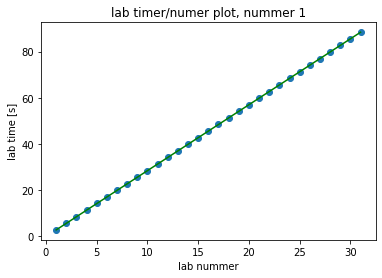

9803.041452283607
0.0403273753230737
1.0


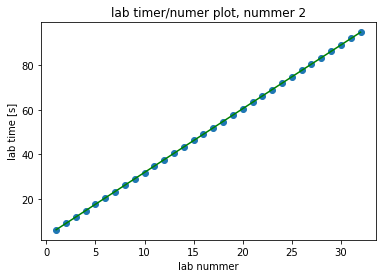

9799.929985580691
0.017252632326007492
1.0


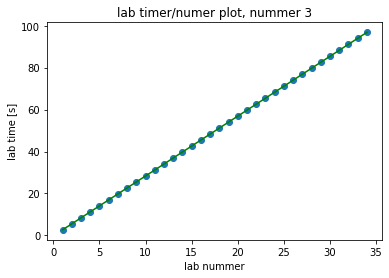

9784.949294233767
0.03252950693732185
1.0


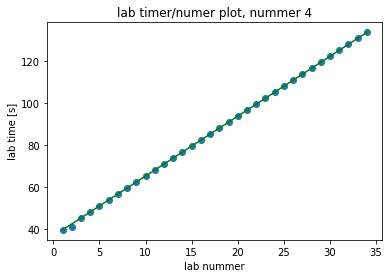

[[2.8520137826081875, -0.02363702899497966],
 [2.8524184615380768, 3.4221596923011397],
 [2.8528712454214222, -0.1760758852229749],
 [2.8550542735043662, 36.553342877495126]]

In [29]:
#first linear fit using iMinuit, without measurement uncertainties.
minuit_line_val_1 = []
for i in range(len(Pen_data)):
    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    x, y = Pen_data[i].Lab, Pen_data[i].Time
    x, y = x[5:-2], y[5:-2] #removing outer points of data
    
    # Defining Chi2 calculation:
    chi2fit = Chi2Regression(line, x, y)

    minuit_chi2_1 = Minuit(chi2fit, a=0.1, b=0)
    minuit_chi2_1.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2_1.migrad()
    
    print(L_mm.mean()*(2*np.pi/minuit_chi2_1.values[:][0])**2) #estimat af g
    print(minuit_chi2_1.fval) #chi2 værdi af fittet
    print(stats.chi2.sf(minuit_chi2_1.fval, len(x)-2)) #len(x)-2 er degrees of freedom, minus 2 kommer fra at vi bruger et linært fit altså 2 parametre
    
    
    minuit_line_val_1.append(minuit_chi2_1.values[:])
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_ylabel('lab time [s]')
    ax.set_xlabel('lab nummer')
    ax.set_title(f'lab timer/numer plot, nummer {i+1}')

    plt.scatter(Pen_data[i].Lab,Pen_data[i].Time)
    ax.plot(Pen_data[i].Lab, line(Pen_data[i].Lab, *minuit_chi2_1.values[:]), '-g', label='Unbinned LLH fit model result') 
    plt.show()

minuit_line_val_1


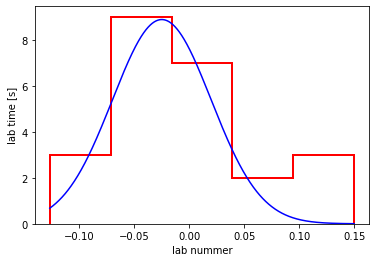

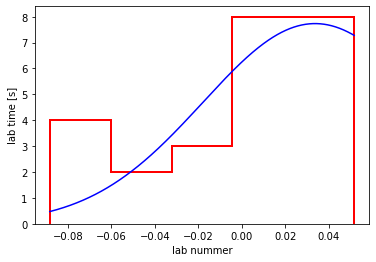

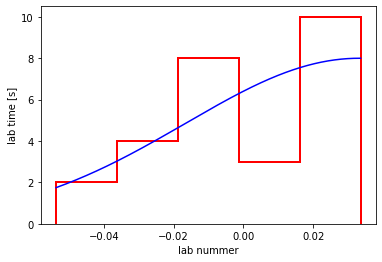

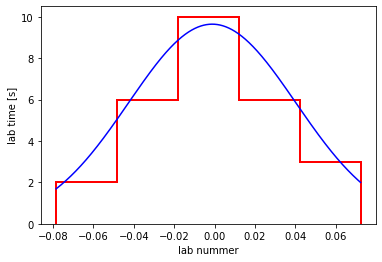

In [31]:
#plot afvigelse af data fra fit på y akse
Nbins = 5
deltay_all = []
minuit_gauss_val = []
for i in range(len(Pen_data)):
    Minuit.print_level = i
    x, y = Pen_data[i].Lab, Pen_data[i].Time
    x, y = x[5:-2], y[5:-2]
    deltay = y - line(x, minuit_line_val_1[i][0],minuit_line_val_1[i][1])
    #deltay_all.extend(deltay)
    
    counts, bin_edges = np.histogram(deltay, bins=Nbins, range=(min(deltay), max(deltay)))

    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    #sy = np.sqrt(counts[counts>0])

    # Defining Chi2 calculation:
    chi2fit = Chi2Regression(gauss_pdf, x, y)

    minuit_chi2_test_error = Minuit(chi2fit, mu=0, sigma=0.1)
    minuit_chi2_test_error.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2_test_error.migrad()
    
    minuit_gauss_val.append(minuit_chi2_test_error.values[:])
    
    
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_ylabel('lab time [s]')
    ax.set_xlabel('lab nummer')
    #ax.set_title(f'lab timer/numer plot, nummer {i+1}')


    
    hist = ax.hist(deltay, bins=Nbins, range=(min(deltay), max(deltay)), histtype='step', linewidth=2, color='red', label='Data, normal histogram')
    
    x_axis = np.linspace(min(deltay), max(deltay), 1000)
    ax.plot(x_axis, gauss_pdf(x_axis, *minuit_chi2_test_error.values[:]), '-b', label='Chi2 fit model result') 
    
    plt.show()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1158                       │              Nfcn = 169              │
│ EDM = 1.1e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

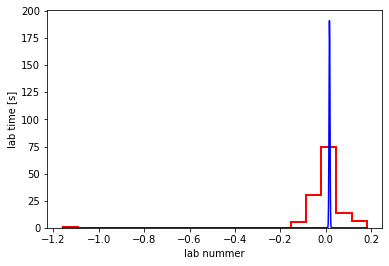

In [11]:
Nbins = 20
deltay_all = []
minuit_gauss_val = []
for i in range(len(Pen_data)):
    x, y = Pen_data[i].Lab, Pen_data[i].Time
    #x, y = x[5:-2], y[5:-2]
    deltay = y - line(x, minuit_line_val[i][0],minuit_line_val[i][1])
    deltay_all.extend(deltay)
    
counts, bin_edges = np.histogram(deltay_all, bins=Nbins, range=(min(deltay_all), max(deltay_all)))

x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
#sy = np.sqrt(counts[counts>0])

# Defining Chi2 calculation:
chi2fit = Chi2Regression(gauss_pdf, x, y)

minuit_chi2_error = Minuit(chi2fit, mu=0, sigma=1)
minuit_chi2_error.errordef = 1.0     # This is the definition for ChiSqaure fits
print(minuit_chi2_error.migrad())
    
minuit_gauss_val.append(minuit_chi2_error.values[:])
    
    
    
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('lab time [s]')
ax.set_xlabel('lab nummer')
#ax.set_title(f'lab timer/numer plot, nummer {i+1}')


    
hist = ax.hist(deltay_all, bins=Nbins, range=(min(deltay_all), max(deltay_all)), histtype='step', linewidth=2, color='red', label='Data, normal histogram')
    
x_axis = np.linspace(min(deltay_all), max(deltay_all), 1000)
ax.plot(x_axis, gauss_pdf(x_axis, *minuit_chi2_error.values[:]), '-b', label='Chi2 fit model result') 
    
plt.show()

In [12]:
minuit_chi2_error.values[:][1]

0.002062111832836278

9811.156336409635


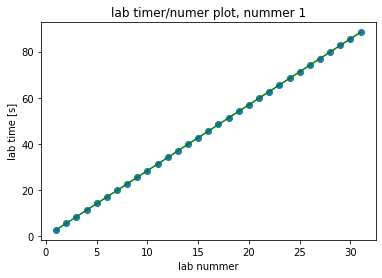

9791.889517127258


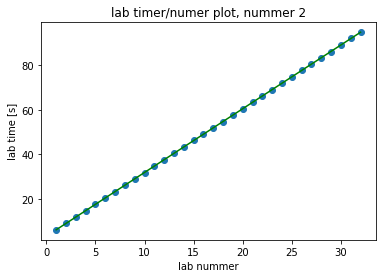

9791.655274407927


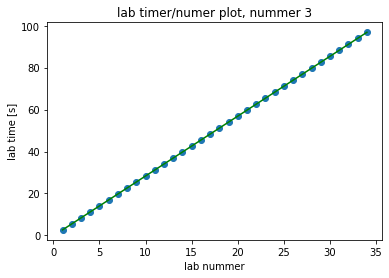

9745.122545455713


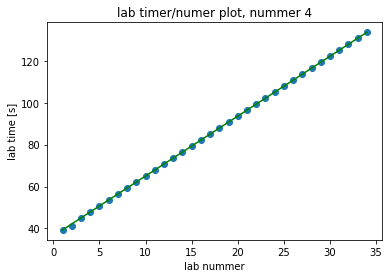

In [13]:
minuit_line_val = []
minuit_line_err = []
for i in range(len(Pen_data)):
    Minuit.print_level = i    # Print result of fits (generally - can also be moved down to each fit instance)
    x, y = Pen_data[i].Lab, Pen_data[i].Time
    #x, y = x[5:-2], y[5:-2]
    sy = minuit_chi2_error.values[:][1]
    # Defining Chi2 calculation:
    chi2fit = Chi2Regression(line, x, y, sy)

    minuit_chi2 = Minuit(chi2fit, a=0.1, b=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()
    print(L_mm.mean()*(2*np.pi/minuit_chi2.values[:][0])**2)
    
    minuit_line_val.append(minuit_chi2.values[:1])
    minuit_line_err.append(minuit_chi2.errors[:1])
    
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_ylabel('lab time [s]')
    ax.set_xlabel('lab nummer')
    ax.set_title(f'lab timer/numer plot, nummer {i+1}')

    plt.scatter(Pen_data[i].Lab,Pen_data[i].Time)
    ax.plot(Pen_data[i].Lab, line(Pen_data[i].Lab, *minuit_chi2.values[:]), '-g', label='Unbinned LLH fit model result') 
    plt.show()
    
T_list = np.array(minuit_line_val)[:,0]
T_err_list = np.array(minuit_line_err)[:,0]
T,T_err = w_mean(T_list,T_err_list)

In [14]:
g = L_mm * (2*np.pi/T)**2

g_err = np.sqrt(((2*np.pi/T)**2)**2 * L_mm_err**2 + (-8*L_mm*(np.pi**2)/T**3)**2 * T_err**2)


print(g,g_err)

9782.821492620138 0.8009508667112675
